# Customer Segmentation & RFM Analysis

**Business Problem:**  
The e-commerce company wants to understand its customer base better.  
Currently, all customers are treated the same in terms of marketing, promotions, and customer service.  
However, different customers contribute differently to the business — some are loyal and high spenders, while others only purchase once.  

By analyzing customer transactions, we will:
- Clean and prepare the data
- Build an RFM (Recency, Frequency, Monetary) segmentation
- Identify top customer groups
- Provide insights for targeted marketing strategies  

This project demonstrates SQL-based customer analytics, a critical skill for data analysts in retail/marketing roles.

# Load Data & Store in SQLite

In [8]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv("Online Retail.csv", encoding='ISO-8859-1', parse_dates=['InvoiceDate'])
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [10]:
# Connect to SQLite database
conn = sqlite3.connect("online_retail.db")

# Load dataset into SQL table
df.to_sql("retail", conn, if_exists='replace', index=False)

# Quick check of raw data from SQL
pd.read_sql_query("SELECT * FROM retail LIMIT 5;", conn)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Data Cleaning

In [16]:
cur = conn.cursor()
cur.execute("""
    CREATE VIEW IF NOT EXISTS retail_clean AS
    SELECT *, 
           Quantity * UnitPrice AS Revenue
    FROM retail
    WHERE CustomerID IS NOT NULL
      AND Quantity > 0
      AND UnitPrice > 0
      AND InvoiceNo NOT LIKE 'C%';
""")
conn.commit()

# Preview cleaned data
pd.read_sql_query("SELECT * FROM retail_clean LIMIT 5;", conn)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


# Basic KPIs

In [26]:
# Number of unique customers
pd.read_sql_query("SELECT COUNT(DISTINCT CustomerID) AS Unique_Customers FROM retail_clean;", conn)

,Unique_Customers
0,4338


In [27]:
# Total revenue
pd.read_sql_query("SELECT ROUND(SUM(Revenue), 2) AS Total_Revenue FROM retail_clean;", conn)

,Total_Revenue
0,8911407.9


In [28]:
# Top 5 countries by revenue
pd.read_sql_query("""
SELECT Country, ROUND(SUM(Revenue),2) AS Revenue
FROM retail_clean
GROUP BY Country
ORDER BY Revenue DESC
LIMIT 5;
""", conn)

,Country,Revenue
0,United Kingdom,7308391.55
1,Netherlands,285446.34
2,EIRE,265545.90
3,Germany,228867.14
4,France,209024.05


# RFM Preparation

In [18]:
# Find latest date in dataset to calculate recency
latest_date = pd.read_sql_query("SELECT MAX(InvoiceDate) AS LatestDate FROM retail_clean;", conn).iloc[0,0]
latest_date


'2011-12-09 12:50:00'

In [29]:
# RFM calculation
query_rfm = f"""
SELECT 
    CustomerID,
    JULIANDAY('{latest_date}') - JULIANDAY(MAX(InvoiceDate)) AS Recency,
    COUNT(DISTINCT InvoiceNo) AS Frequency,
    ROUND(SUM(Revenue),2) AS Monetary
FROM retail_clean
GROUP BY CustomerID;
"""

In [30]:
df_rfm = pd.read_sql_query(query_rfm, conn)

In [31]:
df_rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325.117361,1,77183.60
1,12347.0,1.873611,7,4310.00
2,12348.0,74.984028,4,1797.24
3,12349.0,18.124306,1,1757.55
4,12350.0,309.867361,1,334.40


# RFM Segmentation

In [20]:
# Create a scored view
cur.execute("""
    DROP VIEW IF EXISTS rfm_scores;
""")

cur.execute(f"""
    CREATE VIEW rfm_scores AS
    WITH base AS (
        SELECT 
            CustomerID,
            JULIANDAY('{latest_date}') - JULIANDAY(MAX(InvoiceDate)) AS Recency,
            COUNT(DISTINCT InvoiceNo) AS Frequency,
            ROUND(SUM(Revenue),2) AS Monetary
        FROM retail_clean
        GROUP BY CustomerID
    )
    SELECT *,
           NTILE(4) OVER (ORDER BY Recency DESC) AS R_Score,
           NTILE(4) OVER (ORDER BY Frequency ASC) AS F_Score,
           NTILE(4) OVER (ORDER BY Monetary ASC) AS M_Score
    FROM base;
""")
conn.commit()

# Preview scored customers
pd.read_sql_query("SELECT * FROM rfm_scores LIMIT 5;", conn)

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
0,18074.0,373.122917,1,489.60,1,2,2
1,13747.0,373.092361,1,79.60,1,1,1
2,12791.0,373.057639,1,192.60,1,1,1
3,17908.0,373.045139,1,243.28,1,1,1
4,16583.0,373.032639,1,233.45,1,1,1


# Segment Summary

In [21]:
df_segments = pd.read_sql_query("""
SELECT 
    CustomerID,
    R_Score || F_Score || M_Score AS RFM_Segment,
    R_Score + F_Score + M_Score AS RFM_Score
FROM rfm_scores;
""", conn)

df_segments.head()


,CustomerID,RFM_Segment,RFM_Score
0,18074.0,122,5
1,13747.0,111,3
2,12791.0,111,3
3,17908.0,111,3
4,16583.0,111,3


# High-Value vs Low-Value Customers

In [32]:
# Top 10 customers by RFM score
pd.read_sql_query("""
SELECT CustomerID, R_Score, F_Score, M_Score, (R_Score+F_Score+M_Score) AS Total_Score
FROM rfm_scores
ORDER BY Total_Score DESC
LIMIT 10;
""", conn)

,CustomerID,R_Score,F_Score,M_Score,Total_Score
0,16128.0,4,4,4,12
1,16655.0,4,4,4,12
2,14515.0,4,4,4,12
3,13268.0,4,4,4,12
4,15971.0,4,4,4,12
5,15150.0,4,4,4,12
6,14506.0,4,4,4,12
7,16722.0,4,4,4,12
8,17659.0,4,4,4,12
9,16985.0,4,4,4,12


In [33]:
# Distribution of customers by RFM score
pd.read_sql_query("""
SELECT (R_Score+F_Score+M_Score) AS Total_Score, COUNT(*) AS Num_Customers
FROM rfm_scores
GROUP BY Total_Score
ORDER BY Total_Score DESC;
""", conn)

,Total_Score,Num_Customers
0,12,487
1,11,392
2,10,410
3,9,390
4,8,450
5,7,475
6,6,439
7,5,468
8,4,383
9,3,444


# RFM Distribution Visualizations

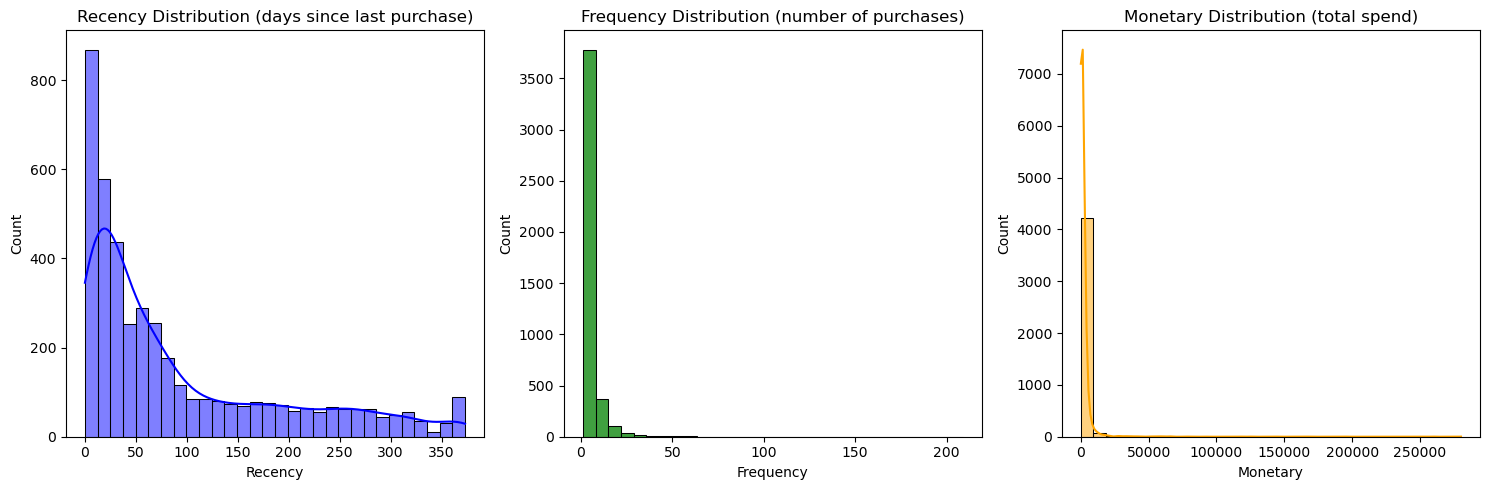

In [39]:
# Load RFM data into pandas
df_rfm = pd.read_sql_query("SELECT * FROM rfm_scores;", conn)

# Histograms
fig, axes = plt.subplots(1, 3, figsize=(15,5))
sns.histplot(df_rfm['Recency'], bins=30, ax=axes[0], kde=True, color="blue")
axes[0].set_title("Recency Distribution (days since last purchase)")

sns.histplot(df_rfm['Frequency'], bins=30, ax=axes[1], kde=False, color="green")
axes[1].set_title("Frequency Distribution (number of purchases)")

sns.histplot(df_rfm['Monetary'], bins=30, ax=axes[2], kde=True, color="orange")
axes[2].set_title("Monetary Distribution (total spend)")

plt.tight_layout()
plt.show()

# Customer Segments Heatmap

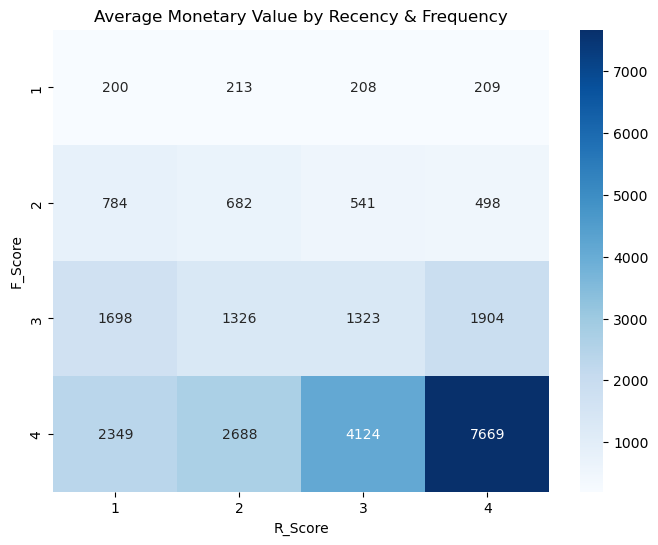

In [44]:
# Create RFM Segment Summary
segment_summary = df_rfm.groupby(['R_Score','F_Score'])['Monetary'].mean().reset_index()

# Pivot for heatmap
heatmap_data = segment_summary.pivot(index='F_Score', columns='R_Score', values='Monetary')

plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="Blues")
plt.title("Average Monetary Value by Recency & Frequency")
plt.show()


# Scatter Plot of RFM Customers

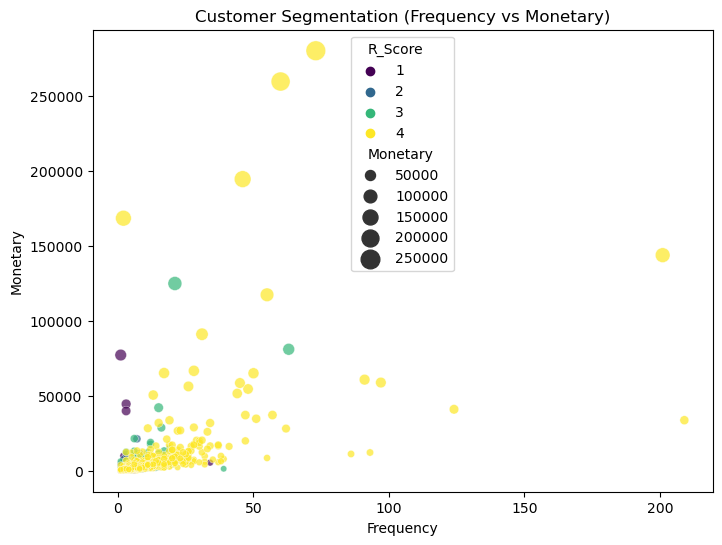

In [25]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='Frequency', y='Monetary', hue='R_Score', size='Monetary', 
                sizes=(20,200), data=df_rfm, palette="viridis", alpha=0.7)
plt.title("Customer Segmentation (Frequency vs Monetary)")
plt.show()

# Final Recommendations

1. **High-Value Customers (High RFM Score)**
   - Reward loyalty with exclusive discounts, VIP programs, and early access to new products.
   - Retain them, as they generate the majority of revenue.

2. **Medium-Value Customers**
   - Encourage repeat purchases with targeted email campaigns and small incentives.
   - They have potential to become loyalists.

3. **Low-Value or At-Risk Customers**
   - Launch win-back campaigns (e.g., personalized discount codes).
   - If inactive for too long, reduce marketing spend to save budget.

4. **Geographic Opportunities**
   - The UK is the biggest market, but customers from other top-5 countries show potential.
   - Localized campaigns could expand revenue outside the UK.